In [37]:
import numpy as np 
import pandas as pd 

# config
DEBUG = True
DATA_SIZE = 20_000
SEED = 20723

# file locations
DATA_LOCATION = '../New_Delhi_reviews.csv'
CLEAN_DATA_LOCATION = '../clean.df'
SAVE_MODEL_LOCATION = '../best_model.h5'

In [38]:
df = pd.read_csv(DATA_LOCATION)
if DEBUG:
    df_example = df.iloc[[4_001,4_002],:]
    print(df_example)
    print(df_example.iloc[0]['review_full'])
    print(np.unique(df['rating_review']))

      rating_review                                        review_full
4001              5  Whenever I have been to this place, it has nev...
4002              4  Been to this Restaurant for a meeting .I was f...
Whenever I have been to this place, it has never let me down. The food is delectable, the staff is cheerful, polite and efficient and the vibe of the place is fantastic. One of the best places in town for a casual meal.
[1 2 3 4 5]


## Preprocessing
### Text cleaning

In [40]:
# imports for text cleaning
import contractions
import re
import nltk
from nltk.corpus import stopwords 
from nltk.corpus import wordnet
from nltk.tokenize import wordpunct_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/veghcsanad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/veghcsanad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


In [41]:
# helper function to convert the pos tag format into something compatible with the lemmatizer
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def clean_doc(doc, stop_words, lemmatizer):
    # expand contractions
    try:
        doc = contractions.fix(doc)
    except:
        if DEBUG:
            print(doc)
        return
    # remove every char that is not alphanumeric, keep spaces
    doc = re.sub(r'\W+', ' ', doc) 
    
    # get lowercase tokens that are not very common words
    tokens = wordpunct_tokenize(doc) 
    tokens = [token.lower() for token in tokens if token.lower() not in stop_words] 
    
    # lemmatize tokens based on pos tags
    pos = pos_tag(tokens)
    clean_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in pos]
    
    # put tokens back into string format for tfidf vectorizer
    #clean_doc = " ".join(clean_tokens)

    return clean_tokens

def clean_data(data):
    en_stop_words = stopwords.words("english")
    wn_lemmatizer = WordNetLemmatizer()
    clean_data = pd.DataFrame()
    clean_data['text'] = data['review_full'].apply(lambda x: clean_doc(x, en_stop_words, wn_lemmatizer))
    clean_data['label'] = data['rating_review']
    clean_data = clean_data.dropna()
    return clean_data

In [42]:
#df_head = df.head(20_000)
#df_head = df.groupby('rating_review', group_keys=False).apply(lambda x: x.head(4_000))
df_head = df.groupby('rating_review', group_keys=False).apply(lambda x: x.sample(n=int(np.ceil(DATA_SIZE / 5)), random_state=SEED))

In [43]:
clean_df = clean_data(df_head)
if DEBUG:
    clean_df_example = clean_data(df_example)
    print(clean_df_example)
    print(clean_df_example.iloc[0]['text'])
    print((clean_df['label'].value_counts()) / len(clean_df) * 100)

                                                   text  label
4001  [whenever, place, never, let, food, delectable...      5
4002  [restaurant, meeting, floor, service, professi...      4
['whenever', 'place', 'never', 'let', 'food', 'delectable', 'staff', 'cheerful', 'polite', 'efficient', 'vibe', 'place', 'fantastic', 'one', 'best', 'place', 'town', 'casual', 'meal']
1    20.0
2    20.0
3    20.0
4    20.0
5    20.0
Name: label, dtype: float64


In [44]:
clean_df.to_pickle(CLEAN_DATA_LOCATION)


### Train-test split

In [45]:
clean_df = pd.read_pickle(CLEAN_DATA_LOCATION)
if DEBUG:
    print(clean_df.head())

                                                     text  label
84507   [want, tell, honest, bad, experience, staff, k...      1
133293  [need, grub, hunger, pang, hour, rendezvous, l...      1
40965   [visit, big, disappointment, service, quality,...      1
136880  [order, chicken, roc, indirapuram, outlet, yes...      1
69512   [advertised, draught, beer, available, magners...      1


In [46]:
train_df = clean_df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.9, random_state=SEED))
test_df = clean_df.drop(train_df.index, axis=0)
if DEBUG:
    print(train_df.head(5))
    print((train_df['label'].value_counts()) / len(train_df) * 100)

                                                     text  label
23051   [nice, environment, loud, loud, music, good, y...      1
84507   [want, tell, honest, bad, experience, staff, k...      1
133293  [need, grub, hunger, pang, hour, rendezvous, l...      1
69512   [advertised, draught, beer, available, magners...      1
56666   [blue, door, cafe, sound, promising, good, rev...      1
1    20.0
2    20.0
3    20.0
4    20.0
5    20.0
Name: label, dtype: float64


### Wordclouds

In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def word_count(words):
    counts = dict()
    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    return counts

def all_word_counts(data, rating):
    data_rated = data[data["label"]==rating]
    data_rated["word_count"] = data_rated["text"].apply(word_count)
    all_counts = {}
    for counts in data_rated["word_count"]:
        for word, count in counts.items():
            if word in all_counts:
                all_counts[word] += count
            else:
                all_counts[word] = count
    return all_counts

def plot_wordcloud(word_freq, rating):           
    wordcloud = WordCloud(width=1000, height=500, background_color="white", colormap='tab10', random_state=SEED).generate_from_frequencies(word_freq)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f'Word Cloud for {rating}-star rating reviews')
    plt.axis("off")
    plt.savefig(f'plot{rating}.png')
    plt.show()
    

all_counts = all_word_counts(train_df, 5)
plot_wordcloud(all_counts, 5)
all_counts = all_word_counts(train_df, 1)
plot_wordcloud(all_counts, 1)

/tmp/ipykernel_47796/1503272378.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rated["word_count"] = data_rated["text"].apply(word_count)


NameError: name 'seed' is not defined

### Encode clean tokens
Explore sequence length distribution

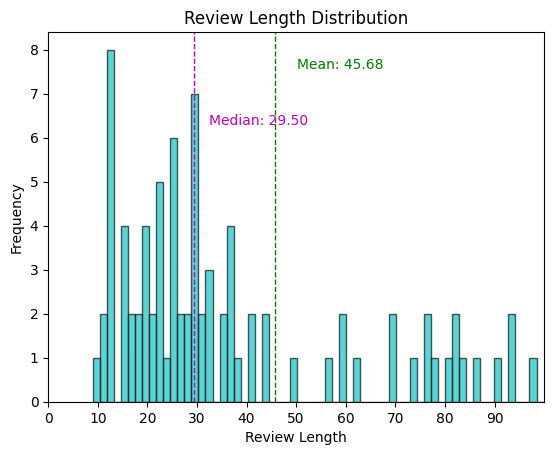

In [47]:
import matplotlib.pyplot as plt

def get_len_dist(data):
    data["len"] = data["text"].apply(lambda x: len(x))
    return data["len"].to_numpy(dtype=int)

def plot_len_dist(lengths):
    plt.hist(lengths, bins=200, color='c', edgecolor='k', alpha=0.65)
    plt.xlabel('Review Length')
    plt.ylabel('Frequency')
    plt.title('Review Length Distribution')
    plt.xlim(0, 100)
    plt.xticks(np.arange(0, 100, 10))
    plt.axvline(np.median(lengths), color='m', linestyle='dashed', linewidth=1)
    plt.axvline(lengths.mean(), color='g', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(np.median(lengths)*1.1, max_ylim*0.75, 'Median: {:.2f}'.format(np.median(lengths)), color='m')
    plt.text(lengths.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(lengths.mean()), color='g')
    plt.show()
    
lens = get_len_dist(train_df)
plot_len_dist(lens)


In [48]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

def vectorize(data, tokenizer=None, max_len=40):
    #max_words = 5000
    # train a new tokenizer
    if tokenizer is None:
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(data)
    sequences = tokenizer.texts_to_sequences(data)
    padded = pad_sequences(sequences, maxlen=max_len)
    return padded, tokenizer

In [49]:
X_train, tokenizer = vectorize(train_df['text'])
y_train = train_df['label'].apply(lambda x: x-1)

VOCAB_SIZE = len(tokenizer.word_index) + 1

if DEBUG:
    print(X_train)
    print(y_train)
    X_example, _ = vectorize(clean_df_example['text'], tokenizer)
    print("Example sequence for report:", X_example[0])
    print(f"Vocabulary size: {VOCAB_SIZE}")

X_test, _ = vectorize(test_df['text'], tokenizer)
y_test = test_df['label']

[[   0    0    0 ...  117    4   46]
 [   0    0    0 ...  199   20  268]
 [ 270  661  662 ...   16  155  205]
 ...
 [   0    0    0 ...   35   72  294]
 [   0    0    0 ...  343 1489    6]
 [   0    0    0 ...  345  195 1494]]
23051     0
84507     0
133293    0
69512     0
56666     0
         ..
98153     4
47847     4
63241     4
19445     4
141987    4
Name: label, Length: 90, dtype: int64
Example sequence for report: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   3  97 600   1  20 566   3 249  19
  53   3 601  40]
Vocabulary size: 1495


## Tuning

In [53]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

In [54]:
def build_model(embedding_size, units, learn_rate, dropout, classes=5, max_len=40):
    model = Sequential()
    model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=embedding_size, input_length=max_len, mask_zero=True))
    model.add(Bidirectional(LSTM(units)))
    model.add(Dropout(dropout))
    model.add(Dense(classes, activation='softmax'))
    
    rmsprop = RMSprop(learning_rate=learn_rate)
    
    model.compile(optimizer=rmsprop, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier

EPOCHS = 10
PATIENCE = 2
ITER = 15
CV = 3

model = KerasClassifier(model=build_model, random_state=SEED, epochs=EPOCHS, callbacks=[EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)])

param_grid = {
    'model__embedding_size': [50, 100, 200],
    'model__units': [64, 128, 256],
    'model__dropout': [0.1, 0.3, 0.5],
    'model__learn_rate': [0.001, 0.005, 0.01],
    'batch_size': [32, 64, 128]
}
rand = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=ITER, n_jobs=-1, cv=CV, random_state=SEED)
rand_result = rand.fit(X_train, y_train)

In [ ]:
res = pd.DataFrame(rand_result.cv_results_)
print("Best: %f using %s" % (rand_result.best_score_, rand_result.best_params_))
means = rand_result.cv_results_['mean_test_score']
stds = rand_result.cv_results_['std_test_score']
params = rand_result.cv_results_['params']
search = pd.DataFrame(params)
search['mean'] = means
search['std'] = stds
search.to_csv("rand_search_15iter_3cv")
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

## Final model

In [ ]:
model = build_model(units=128, learn_rate=0.001, embedding_size=100, dropout=0.5)
if DEBUG:
    model.summary()
    from keras.utils import plot_model
    plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True)

# may want to change this to no validation but idk how many epochs
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)]) 

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

plot_loss(history)

## Evaluation

In [68]:
from sklearn.metrics import accuracy_score
preds = model.predict(X_test)
pred_classes = [np.argmax(line)+1 for line in preds]
print(accuracy_score(y_test, pred_classes))

63/63 [==============================] - 1s 14ms/step
0.647823911955978
